## Intro
In this notebook we train several machine leearning models on a dataset VeReMi.
We vary algorithms, splitting methods, data ingeneering, 

## Librairies

In [1]:
%matplotlib inline

In [4]:
from importlib import reload
from cycler import cycler
from scipy.io  import loadmat
from sklearn   import mixture
from sklearn   import neighbors
from V2XMD     import data_evaluation
from V2XMD     import data_processing
from V2XMD     import data_visualisation
from V2XMD     import plausibility_checks
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import re
import seaborn as sns
import sklearn
import sklearn.metrics
import sys
import time
from V2XMD.models import TrainModel

In [5]:
sns.set_style('dark')

In [6]:
columns_names=[ "type",
                "reception_time",
                "receiver_id",
                "receiver_x_position",
                "receiver_y_position",
                "receiver_z_position",
                "transmission_time" ,
                "transmitter_id",
                "bsm_id",
                "transmitter_x_position",
                "transmitter_y_position",
                "transmitter_z_position",
                "transmitter_x_velocity",
                "transmitter_y_velocity",
                "transmitter_z_velocity",
                "rssi",
                "label"]
dfs=[]

In [7]:
import V2XMD

In [8]:
dfs=[]
for i in [1,2,4,8,16]:
    mat = loadmat('./data/WiSec_DataModifiedVeremi_Dataset-master/attack'+str(i)+'withlabels.mat')['attack'+str(i)+'withlabels']
    df  = pd.DataFrame(mat,columns=columns_names)
    df  = df.assign(dataset=V2XMD.data_visualisation.attack_types[i])
    dfs.append( df)
df = pd.concat(dfs)
df.reset_index(inplace=True,drop=True)
df.dropna(inplace=True)

In [9]:
df.label=df.label.apply(lambda x: V2XMD.data_visualisation.attack_types[x])

In [135]:
# for sample test (Whole data takes a lot of time)
# df=df.sample(frac=0.01)

# Summary statistics

In [136]:
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display( df.describe().T)

,count,mean,std,min,25%,50%,75%,max
type,"1,936,247.00",3.00,0.00,3.00,3.00,3.00,3.00,3.00
reception_time,"1,936,247.00","21,798.31",105.18,"21,600.00","21,704.35","21,817.44","21,885.75","21,960.00"
receiver_id,"1,936,247.00","1,762.73","1,000.00",10.00,964.00,"1,786.00","2,572.00","3,754.00"
receiver_x_position,"1,936,247.00","4,294.37","1,018.20","2,325.42","3,597.83","3,673.08","5,023.85","6,325.00"
receiver_y_position,"1,936,247.00","5,510.63",258.74,"5,180.04","5,255.01","5,470.60","5,738.25","6,079.99"
receiver_z_position,"1,936,247.00",1.89,0.00,1.90,1.90,1.90,1.90,1.90
transmission_time,"1,936,247.00","21,798.31",105.18,"21,600.00","21,704.35","21,817.44","21,885.75","21,960.00"
transmitter_id,"1,936,247.00","1,768.94","1,005.02",7.00,961.00,"1,813.00","2,581.00","3,751.00"
bsm_id,"1,936,247.00","2,560,678.55","1,438,524.18",458.00,"1,312,437.00","2,635,007.00","3,766,269.00","4,984,139.00"
transmitter_x_position,"1,936,247.00","5,020.44","3,288.30",0.42,"3,602.46","3,858.49","5,560.00","27,278.95"


# histograms

In [137]:
df.columns

Index(['type', 'reception_time', 'receiver_id', 'receiver_x_position',
       'receiver_y_position', 'receiver_z_position', 'transmission_time',
       'transmitter_id', 'bsm_id', 'transmitter_x_position',
       'transmitter_y_position', 'transmitter_z_position',
       'transmitter_x_velocity', 'transmitter_y_velocity',
       'transmitter_z_velocity', 'rssi', 'label', 'dataset'],
      dtype='object')

In [138]:
rdf=df[[
 
 'receiver_x_position',
 'transmitter_x_position',
 'receiver_y_position',
 'transmitter_y_position',
 'transmission_time',
 "reception_time",
 'transmitter_x_velocity',
 'transmitter_y_velocity',
 'rssi',
]]

In [139]:
train, test=sklearn.model_selection.train_test_split(df,test_size=0.1)

In [140]:
bsm_ids=test.bsm_id.value_counts().iloc[:10].index

In [141]:
bsm_ids_df=df[df.bsm_id.isin(bsm_ids)]

In [142]:
label_encoder = sklearn.preprocessing.LabelEncoder().fit(bsm_ids_df.bsm_id)

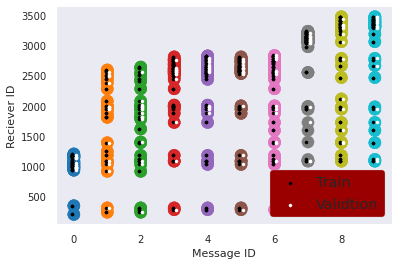

In [143]:
plt.figure()
plt.scatter(label_encoder.transform(bsm_ids_df.bsm_id),bsm_ids_df.receiver_id,c=label_encoder.transform(bsm_ids_df.bsm_id),cmap=plt.cm.tab10,s=150)
plt.scatter(label_encoder.transform(train[train.bsm_id.isin(bsm_ids)].bsm_id)-0.05,train[train.bsm_id.isin(bsm_ids)].receiver_id,c='black',s=10,label='Train')
plt.scatter(label_encoder.transform(test[test.bsm_id.isin(bsm_ids)].bsm_id)+0.05,test[test.bsm_id.isin(bsm_ids)].receiver_id,c='white',s=10,label='Validtion')
plt.xlabel('Message ID')
plt.ylabel('Reciever ID')
plt.legend(fontsize='x-large',facecolor='#9b0000', framealpha=1,frameon = 1)
plt.savefig("out/train_split.png",dpi=300,bbox_inches='tight')

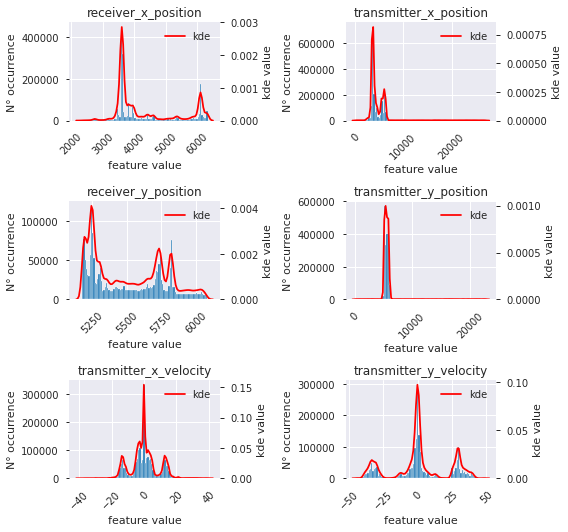

In [144]:
ax=plt.subplots(3,2,figsize=(8,7.5))
caxes=np.concatenate(ax[1]).tolist()
for i,cname in enumerate([
 
 'receiver_x_position',
 'transmitter_x_position',

 'receiver_y_position',
 'transmitter_y_position',

 'transmitter_x_velocity',

 'transmitter_y_velocity',

]):    
    rdf.hist(bins=100,xrot=45,column=cname,ax=caxes[i])
    caxes[i].set_ylabel('N° occurrence')
    caxes[i].set_xlabel('feature value')
    sns.kdeplot(rdf[cname],color='red',label='kde',ax=caxes[i].twinx())
    plt.ylabel('kde value')
plt.tight_layout()
plt.savefig("out/hist_features.png",dpi=300,bbox_inches='tight')

# Box plots

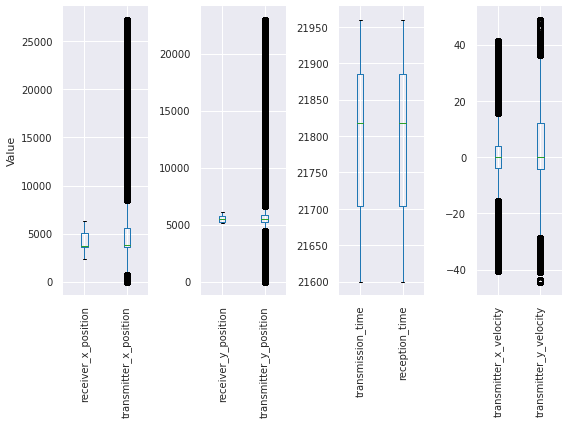

In [145]:
plt.figure(figsize=(8,6))
plt.subplot(141)
df[[
 
 'receiver_x_position',
 'transmitter_x_position',

]].boxplot()
plt.ylabel('Value')
plt.xticks(rotation=90)

plt.tight_layout()
plt.subplot(142)
df[[
 
 'receiver_y_position',
 'transmitter_y_position',
]].boxplot()
plt.xticks(rotation=90)

plt.tight_layout()

plt.subplot(143)

df[[
 'transmission_time',
 "reception_time",
]].boxplot()
plt.xticks(rotation=90)

plt.tight_layout()
plt.subplot(144)

df[[
 'transmitter_x_velocity',
 'transmitter_y_velocity',
]].boxplot()
plt.xticks(rotation=90)
plt.tight_layout()


plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("out/boxplots_features.png",dpi=300,bbox_inches='tight')

## Message reduendency

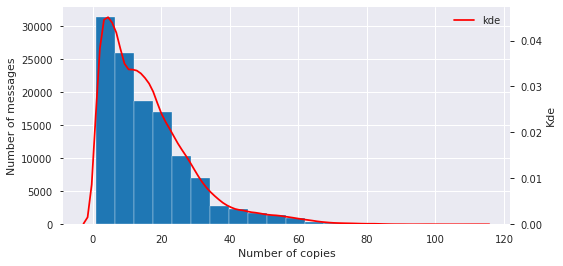

In [147]:
df.groupby('bsm_id').size().hist(bins=20,figsize=(8,4))
plt.ylabel('Number of messages')
plt.xlabel("Number of copies")
plt.twinx()
sns.kdeplot(df.groupby('bsm_id').size(),color='red',label='kde')
plt.legend()
plt.ylabel('Kde')
plt.savefig("out/messaging_rates.png",dpi=600,bbox_inches='tight');

# Machine learning application

## Expiriments. 
#### We variate the following parameters in heirarchical setup with this order. 
    MBD type (Message based)
    Split type (random and spatio-temporal split)
    feature engineering ( use or not of extracted features)
    One classe detection (a model for each class of misbehavior VS a model for all classes at the same time)

## Message based detection

### Random split

#### No feature engineering
 


##### One classe detection at a time

In [82]:
rnd_nofeature_oneclass_model= TrainModel(df,split='random', multi_class=False,features=False)
rnd_nofeature_oneclass_model.train()

In [83]:
rnd_nofeature_oneclass_model.train_results

Algo                                              AdaBoost            \
                                                  f1-score precision   
Attack          split  Set   features multiclass                       
Constant        random train False    False       1.000000  1.000000   
Constant offset random train False    False       0.946237  0.972376   
Eventual stop   random train False    False       0.676218  0.802721   
Genuine         random train False    False       0.955913  0.934805   
Random          random train False    False       0.995902  1.000000   
Random offset   random train False    False       0.726563  0.885714   

Algo                                                       Decision Tree  \
                                                    recall      f1-score   
Attack          split  Set   features multiclass                           
Constant        random train False    False       1.000000      1.000000   
Constant offset random train False    False       0.921466      0.968586   
Eventual stop   random train False    False       0.584158      0.893300   
Genuine         random train False    False       0.979201      0.975747   
Random          random train False    False       0.991837      0.995902   
Random offset   random train False    False       0.615894      0.821053   

Algo                                                                  \
                                                 precision    recall   
Attack          split  Set   features multiclass                       
Constant        random train False    False       1.000000  1.000000   
Constant offset random train False    False       0.968586  0.968586   
Eventual stop   random train False    False       0.895522  0.891089   
Genuine         random train False    False       0.971516  0.980117   
Random          random train False    False       1.000000  0.991837   
Random offset   random train False    False       0.873134  0.774834   

Algo                                             Naive Bayes            \
                                                    f1-score precision   
Attack          split  Set   features multiclass                         
Constant        random train False    False         1.000000  1.000000   
Constant offset random train False    False         0.142857  0.789474   
Eventual stop   random train False    False         0.305882  0.735849   
Genuine         random train False    False         0.898940  0.840091   
Random          random train False    False         0.993840  1.000000   
Random offset   random train False    False         0.246445  0.433333   

Algo                                                       Nearest Neighbors  \
                                                    recall          f1-score   
Attack          split  Set   features multiclass                               
Constant        random train False    False       1.000000          0.980057   
Constant offset random train False    False       0.078534          0.918033   
Eventual stop   random train False    False       0.193069          0.760705   
Genuine         random train False    False       0.976442          0.948134   
Random          random train False    False       0.987755          0.989691   
Random offset   random train False    False       0.172185          0.518868   

Algo                                                                  \
                                                 precision    recall   
Attack          split  Set   features multiclass                       
Constant        random train False    False       0.960894  1.000000   
Constant offset random train False    False       0.960000  0.879581   
Eventual stop   random train False    False       0.774359  0.747525   
Genuine         random train False    False       0.928735  0.970825   
Random          random train False    False       1.000000  0.979592   
Random offset   random train False    False       0.9

##### train results

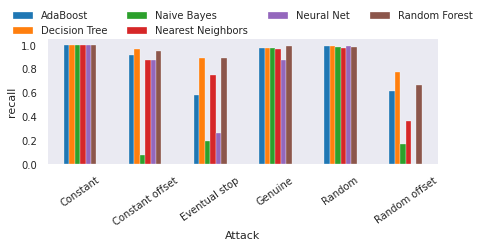

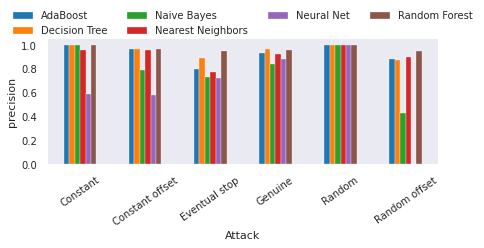

In [84]:
rnd_nofeature_oneclass_model.results_visualisation('train')

##### test results

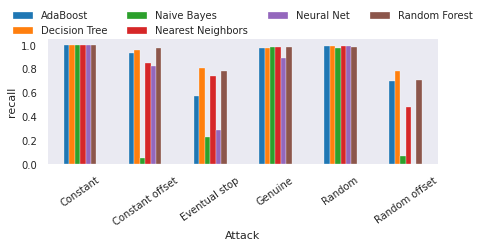

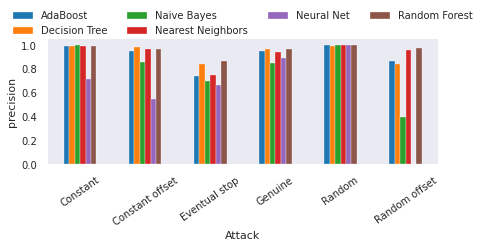

In [85]:
rnd_nofeature_oneclass_model.results_visualisation('test')

##### Multi class detection

In [86]:
rnd_nofeature_multiclass_model= TrainModel(df,split='random', multi_class=True,features=False)
rnd_nofeature_multiclass_model.train()

In [87]:
rnd_nofeature_multiclass_model.train_results

Algo                                              AdaBoost            \
                                                  f1-score precision   
Attack          split  Set   features multiclass                       
Constant        random train False    True        0.997347  0.994709   
Constant offset random train False    True        0.000000  0.000000   
Eventual stop   random train False    True        0.000000  0.000000   
Genuine         random train False    True        0.888934  0.800662   
Random          random train False    True        0.986737  0.989362   
Random offset   random train False    True        0.022346  1.000000   

Algo                                                       Decision Tree  \
                                                    recall      f1-score   
Attack          split  Set   features multiclass                           
Constant        random train False    True        1.000000      0.997347   
Constant offset random train False    True        0.000000      0.890080   
Eventual stop   random train False    True        0.000000      0.857143   
Genuine         random train False    True        0.999082      0.972031   
Random          random train False    True        0.984127      0.992000   
Random offset   random train False    True        0.011299      0.710227   

Algo                                                                  \
                                                 precision    recall   
Attack          split  Set   features multiclass                       
Constant        random train False    True        0.994709  1.000000   
Constant offset random train False    True        0.907104  0.873684   
Eventual stop   random train False    True        0.840659  0.874286   
Genuine         random train False    True        0.971141  0.972923   
Random          random train False    True        1.000000  0.984127   
Random offset   random train False    True        0.714286  0.706215   

Algo                                             Naive Bayes            \
                                                    f1-score precision   
Attack          split  Set   features multiclass                         
Constant        random train False    True          1.000000  1.000000   
Constant offset random train False    True          0.000000  0.000000   
Eventual stop   random train False    True          0.000000  0.000000   
Genuine         random train False    True          0.888844  0.799927   
Random          random train False    True          0.992000  1.000000   
Random offset   random train False    True          0.000000  0.000000   

Algo                                                       Nearest Neighbors  \
                                                    recall          f1-score   
Attack          split  Set   features multiclass                               
Constant        random train False    True        1.000000          0.963351   
Constant offset random train False    True        0.000000          0.825974   
Eventual stop   random train False    True        0.000000          0.606250   
Genuine         random train False    True        1.000000          0.942478   
Random          random train False    True        0.984127          0.986595   
Random offset   random train False    True        0.000000          0.305556   

Algo                                                                  \
                                                 precision    recall   
Attack          split  Set   features multiclass                       
Constant        random train False    True        0.948454  0.978723   
Constant offset random train False    True        0.815385  0.836842   
Eventual stop   random train False    True        0.668966  0.554286   
Genuine         random train False    True        0.909868  0.977513   
Random          random train False    True        1.000000  0.973545   
Random offset   random train False    True        0.8

##### train results

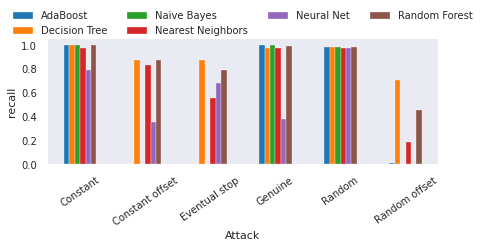

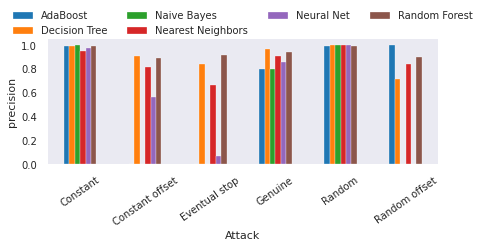

In [88]:
rnd_nofeature_multiclass_model.results_visualisation('train')

##### test results

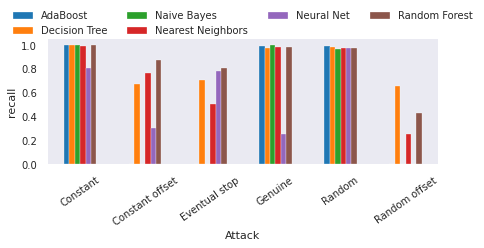

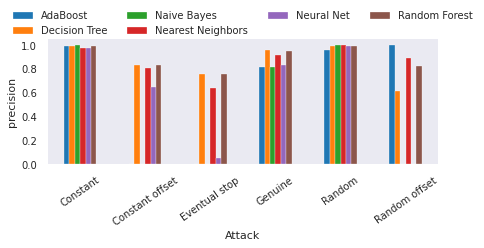

In [89]:
rnd_nofeature_multiclass_model.results_visualisation('test')

#### With feature engineering


##### One classe detection at a time

In [90]:
rnd_feature_oneclass_model= TrainModel(df,split='random', multi_class=False,features=True)
rnd_feature_oneclass_model.train()

In [91]:
rnd_feature_oneclass_model.train_results

Algo                                              AdaBoost            \
                                                  f1-score precision   
Attack          split  Set   features multiclass                       
Constant        random train True     False       1.000000  1.000000   
Constant offset random train True     False       0.954023  0.994012   
Eventual stop   random train True     False       0.753333  0.875969   
Genuine         random train True     False       0.966831  0.952716   
Random          random train True     False       1.000000  1.000000   
Random offset   random train True     False       0.745098  0.791667   

Algo                                                       Decision Tree  \
                                                    recall      f1-score   
Attack          split  Set   features multiclass                           
Constant        random train True     False       1.000000      1.000000   
Constant offset random train True     False       0.917127      0.967213   
Eventual stop   random train True     False       0.660819      0.885057   
Genuine         random train True     False       0.981956      0.977791   
Random          random train True     False       1.000000      1.000000   
Random offset   random train True     False       0.703704      0.823105   

Algo                                                                  \
                                                 precision    recall   
Attack          split  Set   features multiclass                       
Constant        random train True     False       1.000000  1.000000   
Constant offset random train True     False       0.956757  0.977901   
Eventual stop   random train True     False       0.870056  0.900585   
Genuine         random train True     False       0.981436  0.974192   
Random          random train True     False       1.000000  1.000000   
Random offset   random train True     False       0.802817  0.844444   

Algo                                             Naive Bayes            \
                                                    f1-score precision   
Attack          split  Set   features multiclass                         
Constant        random train True     False         0.991957  1.000000   
Constant offset random train True     False         0.555874  0.577381   
Eventual stop   random train True     False         0.595745  0.756757   
Genuine         random train True     False         0.915276  0.891170   
Random          random train True     False         1.000000  1.000000   
Random offset   random train True     False         0.390244  0.571429   

Algo                                                       Nearest Neighbors  \
                                                    recall          f1-score   
Attack          split  Set   features multiclass                               
Constant        random train True     False       0.984043          0.994652   
Constant offset random train True     False       0.535912          0.919220   
Eventual stop   random train True     False       0.491228          0.779944   
Genuine         random train True     False       0.942327          0.956221   
Random          random train True     False       1.000000          0.995455   
Random offset   random train True     False       0.296296          0.547264   

Algo                                                                  \
                                                 precision    recall   
Attack          split  Set   features multiclass                       
Constant        random train True     False       1.000000  0.989362   
Constant offset random train True     False       0.926966  0.911602   
Eventual stop   random train True     False       0.744681  0.818713   
Genuine         random train True     False       0.947344  0.966787   
Random          random train True     False       1.000000  0.990950   
Random offset   random train True     False       0.8

##### train results

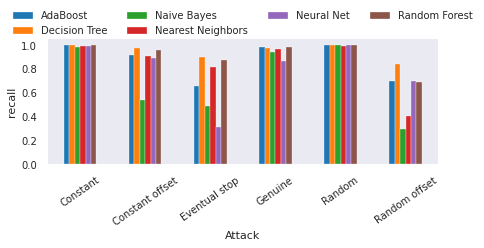

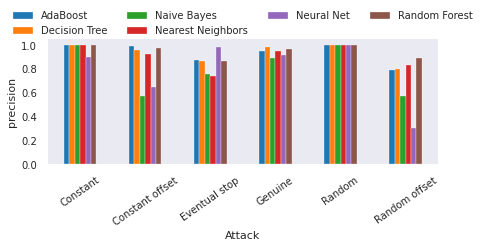

In [92]:
rnd_feature_oneclass_model.results_visualisation('train')

##### test results

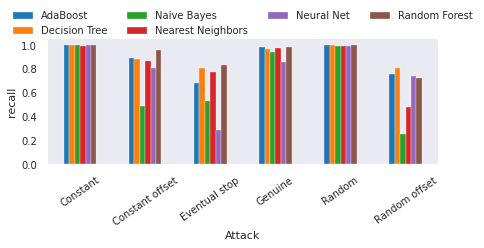

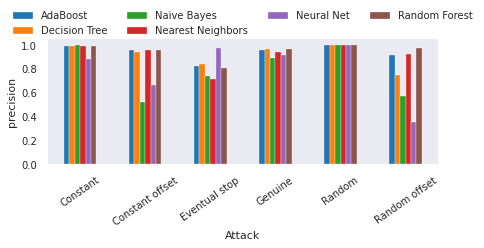

In [93]:
rnd_feature_oneclass_model.results_visualisation('test')

##### Multi class detection

In [94]:
rnd_feature_multiclass_model= TrainModel(df,split='random', multi_class=True,features=True)
rnd_feature_multiclass_model.train()

In [95]:
rnd_feature_multiclass_model.train_results

Algo                                              AdaBoost            \
                                                  f1-score precision   
Attack          split  Set   features multiclass                       
Constant        random train True     True        1.000000  1.000000   
Constant offset random train True     True        0.277523  0.179259   
Eventual stop   random train True     True        0.281755  0.269912   
Genuine         random train True     True        0.799698  0.862969   
Random          random train True     True        0.483776  0.836735   
Random offset   random train True     True        0.009662  0.013889   

Algo                                                       Decision Tree  \
                                                    recall      f1-score   
Attack          split  Set   features multiclass                           
Constant        random train True     True        1.000000      0.994709   
Constant offset random train True     True        0.614213      0.905371   
Eventual stop   random train True     True        0.294686      0.814815   
Genuine         random train True     True        0.745070      0.968918   
Random          random train True     True        0.340249      0.995833   
Random offset   random train True     True        0.007407      0.676806   

Algo                                                                  \
                                                 precision    recall   
Attack          split  Set   features multiclass                       
Constant        random train True     True        0.989474  1.000000   
Constant offset random train True     True        0.912371  0.898477   
Eventual stop   random train True     True        0.833333  0.797101   
Genuine         random train True     True        0.964635  0.973239   
Random          random train True     True        1.000000  0.991701   
Random offset   random train True     True        0.695312  0.659259   

Algo                                             Naive Bayes            \
                                                    f1-score precision   
Attack          split  Set   features multiclass                         
Constant        random train True     True          0.991957  1.000000   
Constant offset random train True     True          0.169742  0.310811   
Eventual stop   random train True     True          0.388747  0.413043   
Genuine         random train True     True          0.889678  0.843789   
Random          random train True     True          0.971545  0.952191   
Random offset   random train True     True          0.085366  0.241379   

Algo                                                       Nearest Neighbors  \
                                                    recall          f1-score   
Attack          split  Set   features multiclass                               
Constant        random train True     True        0.984043          0.966057   
Constant offset random train True     True        0.116751          0.861538   
Eventual stop   random train True     True        0.367150          0.632432   
Genuine         random train True     True        0.940845          0.945719   
Random          random train True     True        0.991701          0.991632   
Random offset   random train True     True        0.051852          0.325581   

Algo                                                                  \
                                                 precision    recall   
Attack          split  Set   features multiclass                       
Constant        random train True     True        0.948718  0.984043   
Constant offset random train True     True        0.870466  0.852792   
Eventual stop   random train True     True        0.717791  0.565217   
Genuine         random train True     True        0.915970  0.977465   
Random          random train True     True        1.000000  0.983402   
Random offset   random train True     True        0.7

##### train results

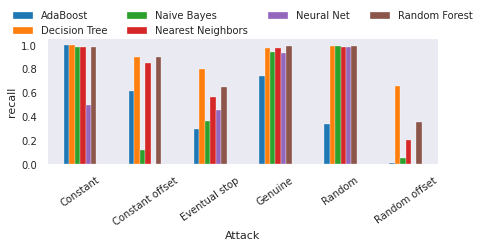

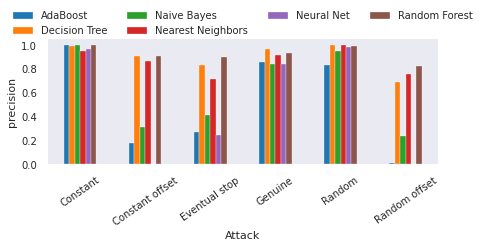

In [96]:
rnd_feature_multiclass_model.results_visualisation('train')

##### test results

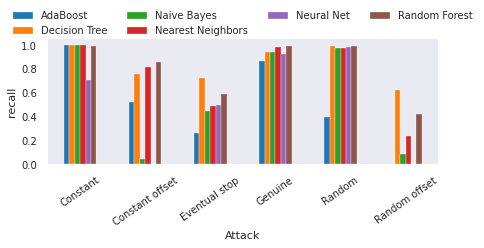

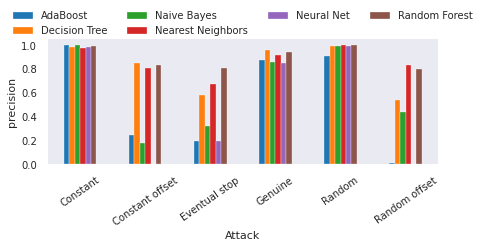

In [97]:
rnd_feature_multiclass_model.results_visualisation('test')

### Spatiotemporal split

#### No feature engineering
 


##### One classe detection at a time

In [98]:
tmp_nofeature_oneclass_model= TrainModel(df,split='our', multi_class=False,features=False)
tmp_nofeature_oneclass_model.train()

In [99]:
tmp_nofeature_oneclass_model.train_results

Algo                                             AdaBoost                      \
                                                 f1-score precision    recall   
Attack          split Set   features multiclass                                 
Constant        our   train False    False       0.997519  0.995050  1.000000   
Constant offset our   train False    False       0.950920  0.968750  0.933735   
Eventual stop   our   train False    False       0.676385  0.778523  0.597938   
Genuine         our   train False    False       0.953757  0.932317  0.977726   
Random          our   train False    False       0.995575  1.000000  0.991189   
Random offset   our   train False    False       0.655022  0.914634  0.510204   

Algo                                            Decision Tree            \
                                                     f1-score precision   
Attack          split Set   features multiclass                           
Constant        our   train False    False           0.997519  0.995050   
Constant offset our   train False    False           0.975309  1.000000   
Eventual stop   our   train False    False           0.836565  0.904192   
Genuine         our   train False    False           0.966378  0.958477   
Random          our   train False    False           0.995575  1.000000   
Random offset   our   train False    False           0.727891  0.727891   

Algo                                                      Naive Bayes  \
                                                   recall    f1-score   
Attack          split Set   features multiclass                         
Constant        our   train False    False       1.000000    1.000000   
Constant offset our   train False    False       0.951807    0.102857   
Eventual stop   our   train False    False       0.778351    0.261224   
Genuine         our   train False    False       0.974718    0.903655   
Random          our   train False    False       0.991189    0.986607   
Random offset   our   train False    False       0.727891    0.130178   

Algo                                                                 \
                                                precision    recall   
Attack          split Set   features multiclass                       
Constant        our   train False    False       1.000000  1.000000   
Constant offset our   train False    False       1.000000  0.054217   
Eventual stop   our   train False    False       0.627451  0.164948   
Genuine         our   train False    False       0.841265  0.985762   
Random          our   train False    False       1.000000  0.973568   
Random offset   our   train False    False       0.500000  0.074830   

Algo                                            Nearest Neighbors            \
                                                         f1-score precision   
Attack          split Set   features multiclass                               
Constant        our   train False    False               0.987715  0.975728   
Constant offset our   train False    False               0.910256  0.972603   
Eventual stop   our   train False    False               0.779221  0.785340   
Genuine         our   train False    False               0.952233  0.934857   
Random          our   train False    False               0.988864  1.000000   
Random offset   our   train False    False               0.571429  0.885714   

Algo                                                      Neural Net  \
                                                   recall   f1-score   
Attack          split Set   features multiclass                        
Constant        our   train False    False       1.000000   0.872017   
Constant offset our   train False    False       0.855422   0.599222   
Eventual stop   our   train False    False       0.773196   0.657061   
Genuine         our   train False    False       0.971841   0.876283   
Random          our   train False    False       0.977974   1.000000   
Random o

##### train results

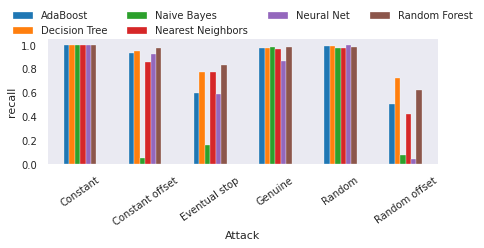

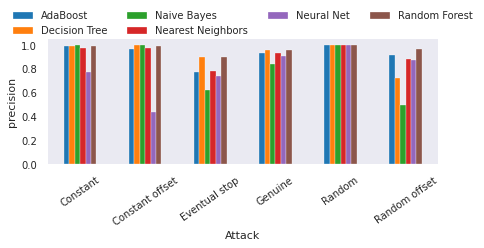

In [100]:
tmp_nofeature_oneclass_model.results_visualisation('train')

##### test results

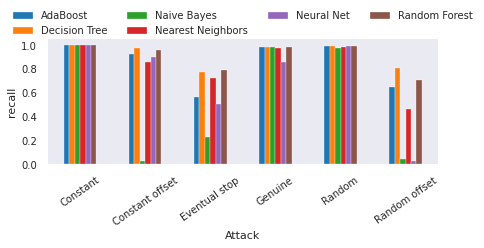

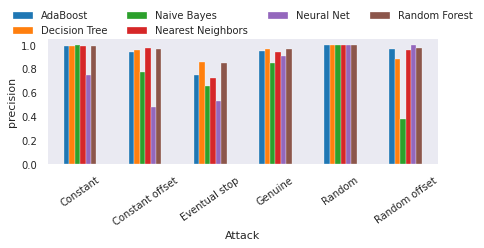

In [101]:
tmp_nofeature_oneclass_model.results_visualisation('test')

##### Multi class detection

In [102]:
tmp_nofeature_multiclass_model= TrainModel(df,split='our', multi_class=True,features=False)
tmp_nofeature_multiclass_model.train()

In [103]:
tmp_nofeature_multiclass_model.train_results

Algo                                             AdaBoost                      \
                                                 f1-score precision    recall   
Attack          split Set   features multiclass                                 
Constant        our   train False    True        0.000000  0.000000  0.000000   
Constant offset our   train False    True        0.451064  0.768116  0.319277   
Eventual stop   our   train False    True        0.000000  0.000000  0.000000   
Genuine         our   train False    True        0.871000  0.771480  1.000000   
Random          our   train False    True        0.991150  0.995556  0.986784   
Random offset   our   train False    True        0.000000  0.000000  0.000000   

Algo                                            Decision Tree            \
                                                     f1-score precision   
Attack          split Set   features multiclass                           
Constant        our   train False    True            0.997519  0.995050   
Constant offset our   train False    True            0.905325  0.889535   
Eventual stop   our   train False    True            0.801034  0.803109   
Genuine         our   train False    True            0.969767  0.968649   
Random          our   train False    True            0.988962  0.991150   
Random offset   our   train False    True            0.640845  0.664234   

Algo                                                      Naive Bayes  \
                                                   recall    f1-score   
Attack          split Set   features multiclass                         
Constant        our   train False    True        1.000000     1.00000   
Constant offset our   train False    True        0.921687     0.00000   
Eventual stop   our   train False    True        0.798969     0.00000   
Genuine         our   train False    True        0.970887     0.89440   
Random          our   train False    True        0.986784     0.98434   
Random offset   our   train False    True        0.619048     0.00000   

Algo                                                                 \
                                                precision    recall   
Attack          split Set   features multiclass                       
Constant        our   train False    True        1.000000  1.000000   
Constant offset our   train False    True        0.000000  0.000000   
Eventual stop   our   train False    True        0.000000  0.000000   
Genuine         our   train False    True        0.808972  1.000000   
Random          our   train False    True        1.000000  0.969163   
Random offset   our   train False    True        0.000000  0.000000   

Algo                                            Nearest Neighbors            \
                                                         f1-score precision   
Attack          split Set   features multiclass                               
Constant        our   train False    True                0.963325  0.947115   
Constant offset our   train False    True                0.778761  0.763006   
Eventual stop   our   train False    True                0.619318  0.689873   
Genuine         our   train False    True                0.944730  0.915835   
Random          our   train False    True                0.977477  1.000000   
Random offset   our   train False    True                0.313514  0.763158   

Algo                                                      Neural Net  \
                                                   recall   f1-score   
Attack          split Set   features multiclass                        
Constant        our   train False    True        0.980100   0.871332   
Constant offset our   train False    True        0.795181   0.023810   
Eventual stop   our   train False    True        0.561856   0.195349   
Genuine         our   train False    True        0.975508   0.901462   
Random          our   train False    True        0.955947   0.961373   
Random o

##### train results

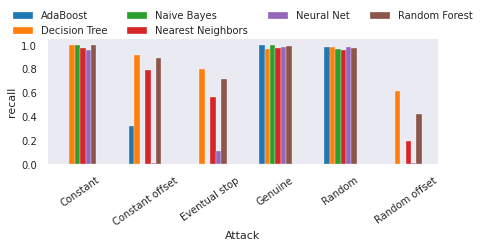

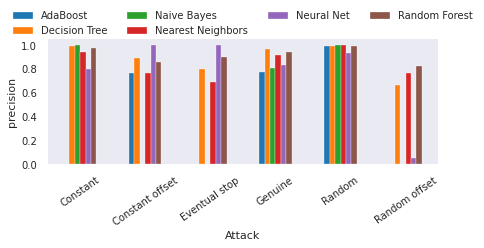

In [104]:
tmp_nofeature_multiclass_model.results_visualisation('train')

##### test results

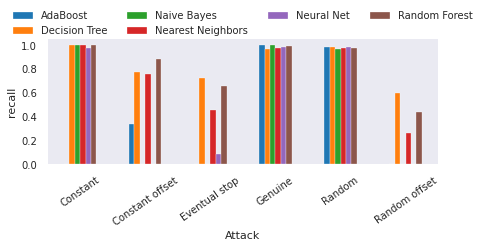

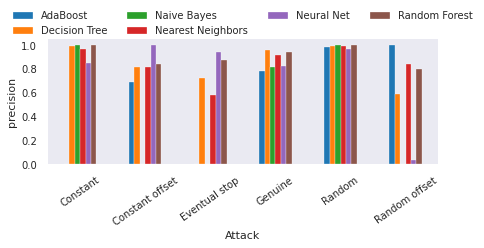

In [105]:
tmp_nofeature_multiclass_model.results_visualisation('test')

#### With feature engineering


##### One classe detection at a time

In [106]:
tmp_feature_oneclass_model= TrainModel(df,split='our', multi_class=False,features=True)
tmp_feature_oneclass_model.train()

In [107]:
tmp_feature_oneclass_model.train_results

Algo                                             AdaBoost                      \
                                                 f1-score precision    recall   
Attack          split Set   features multiclass                                 
Constant        our   train True     False       0.997519  0.995050  1.000000   
Constant offset our   train True     False       0.951515  0.957317  0.945783   
Eventual stop   our   train True     False       0.777143  0.871795  0.701031   
Genuine         our   train True     False       0.962792  0.947992  0.978875   
Random          our   train True     False       1.000000  1.000000  1.000000   
Random offset   our   train True     False       0.715953  0.836364  0.625850   

Algo                                            Decision Tree            \
                                                     f1-score precision   
Attack          split Set   features multiclass                           
Constant        our   train True     False           0.997519  0.995050   
Constant offset our   train True     False           0.963415  0.975309   
Eventual stop   our   train True     False           0.857909  0.893855   
Genuine         our   train True     False           0.971758  0.966754   
Random          our   train True     False           1.000000  1.000000   
Random offset   our   train True     False           0.795848  0.809859   

Algo                                                      Naive Bayes  \
                                                   recall    f1-score   
Attack          split Set   features multiclass                         
Constant        our   train True     False       1.000000    0.992481   
Constant offset our   train True     False       0.951807    0.574850   
Eventual stop   our   train True     False       0.824742    0.710059   
Genuine         our   train True     False       0.976910    0.916662   
Random          our   train True     False       1.000000    1.000000   
Random offset   our   train True     False       0.782313    0.285714   

Algo                                                                 \
                                                precision    recall   
Attack          split Set   features multiclass                       
Constant        our   train True     False       1.000000  0.985075   
Constant offset our   train True     False       0.571429  0.578313   
Eventual stop   our   train True     False       0.833333  0.618557   
Genuine         our   train True     False       0.893629  0.943203   
Random          our   train True     False       1.000000  1.000000   
Random offset   our   train True     False       0.476190  0.204082   

Algo                                            Nearest Neighbors            \
                                                         f1-score precision   
Attack          split Set   features multiclass                               
Constant        our   train True     False               0.987715  0.975728   
Constant offset our   train True     False               0.911392  0.960000   
Eventual stop   our   train True     False               0.780612  0.772727   
Genuine         our   train True     False               0.951998  0.938912   
Random          our   train True     False               0.995575  1.000000   
Random offset   our   train True     False               0.577778  0.833333   

Algo                                                      Neural Net  \
                                                   recall   f1-score   
Attack          split Set   features multiclass                        
Constant        our   train True     False       1.000000   0.972152   
Constant offset our   train True     False       0.867470   0.638596   
Eventual stop   our   train True     False       0.788660   0.630332   
Genuine         our   train True     False       0.966866   0.850917   
Random          our   train True     False       0.991189   0.997802   
Random o

##### train results

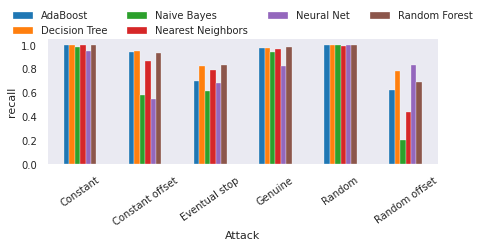

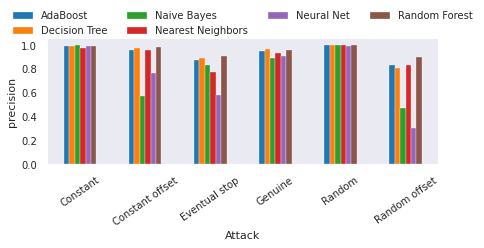

In [108]:
tmp_feature_oneclass_model.results_visualisation('train')

##### test results

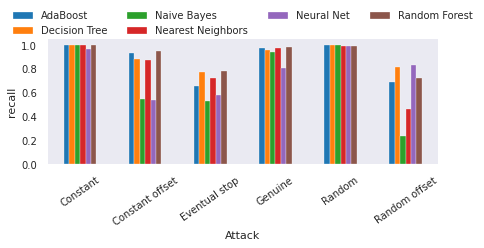

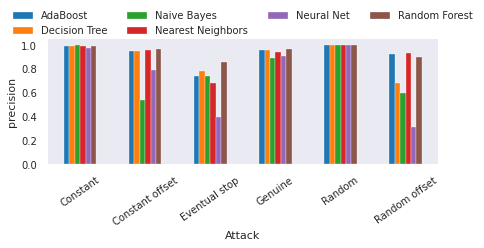

In [109]:
tmp_feature_oneclass_model.results_visualisation('test')

##### Multi class detection

In [110]:
tmp_feature_multiclass_model= TrainModel(df,split='our', multi_class=True,features=True)
tmp_feature_multiclass_model.train()

In [111]:
tmp_feature_multiclass_model.train_results

Algo                                             AdaBoost                      \
                                                 f1-score precision    recall   
Attack          split Set   features multiclass                                 
Constant        our   train True     True        0.753304  0.675889  0.850746   
Constant offset our   train True     True        0.435897  0.750000  0.307229   
Eventual stop   our   train True     True        0.000000  0.000000  0.000000   
Genuine         our   train True     True        0.921210  0.854265  0.999538   
Random          our   train True     True        0.953390  0.918367  0.991189   
Random offset   our   train True     True        0.013514  1.000000  0.006803   

Algo                                            Decision Tree            \
                                                     f1-score precision   
Attack          split Set   features multiclass                           
Constant        our   train True     True            0.997519  0.995050   
Constant offset our   train True     True            0.837349  0.837349   
Eventual stop   our   train True     True            0.729064  0.698113   
Genuine         our   train True     True            0.959870  0.963670   
Random          our   train True     True            0.986726  0.991111   
Random offset   our   train True     True            0.605442  0.605442   

Algo                                                      Naive Bayes  \
                                                   recall    f1-score   
Attack          split Set   features multiclass                         
Constant        our   train True     True        1.000000    0.992481   
Constant offset our   train True     True        0.837349    0.132231   
Eventual stop   our   train True     True        0.762887    0.504854   
Genuine         our   train True     True        0.956100    0.898564   
Random          our   train True     True        0.982379    0.988962   
Random offset   our   train True     True        0.605442    0.071856   

Algo                                                                 \
                                                precision    recall   
Attack          split Set   features multiclass                       
Constant        our   train True     True        1.000000  0.985075   
Constant offset our   train True     True        0.210526  0.096386   
Eventual stop   our   train True     True        0.477064  0.536082   
Genuine         our   train True     True        0.861076  0.939464   
Random          our   train True     True        0.991150  0.986784   
Random offset   our   train True     True        0.300000  0.040816   

Algo                                            Nearest Neighbors            \
                                                         f1-score precision   
Attack          split Set   features multiclass                               
Constant        our   train True     True                0.960976  0.942584   
Constant offset our   train True     True                0.777448  0.766082   
Eventual stop   our   train True     True                0.612360  0.672840   
Genuine         our   train True     True                0.944122  0.914286   
Random          our   train True     True                0.984340  1.000000   
Random offset   our   train True     True                0.229885  0.740741   

Algo                                                      Neural Net  \
                                                   recall   f1-score   
Attack          split Set   features multiclass                        
Constant        our   train True     True        0.980100   0.791919   
Constant offset our   train True     True        0.789157   0.475992   
Eventual stop   our   train True     True        0.561856   0.160377   
Genuine         our   train True     True        0.975970   0.903754   
Random          our   train True     True        0.969163   0.957447   
Random o

##### train results

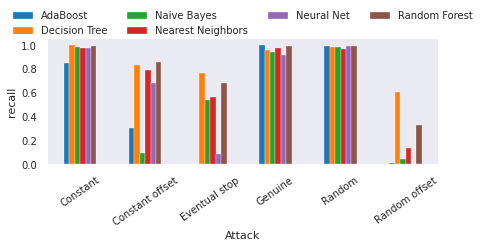

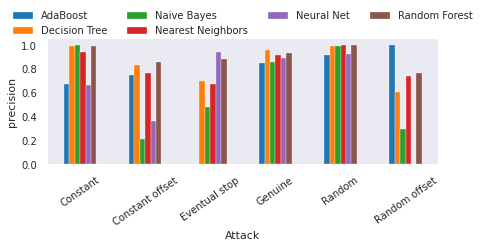

In [112]:
tmp_feature_multiclass_model.results_visualisation('train')

##### test results

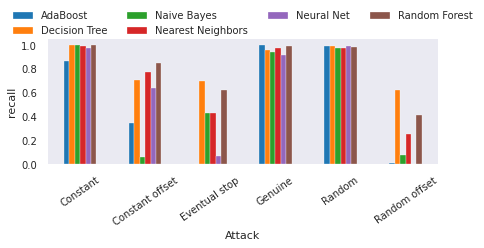

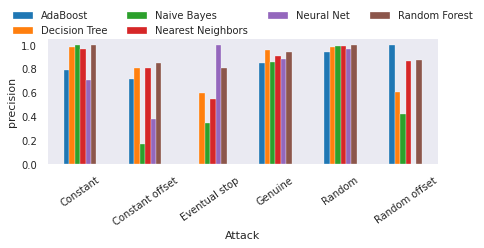

In [113]:
tmp_feature_multiclass_model.results_visualisation('test')

# Comparison 

In [114]:
all_results=pd.concat([
        
    rnd_nofeature_oneclass_model.train_results,
    rnd_nofeature_oneclass_model.test_results,
    rnd_nofeature_multiclass_model.train_results,
    rnd_nofeature_multiclass_model.test_results,
    rnd_feature_oneclass_model.train_results,
    rnd_feature_oneclass_model.test_results,
    rnd_feature_multiclass_model.train_results,
    rnd_feature_multiclass_model.test_results,
    tmp_nofeature_oneclass_model.train_results,
    tmp_nofeature_oneclass_model.test_results,
    tmp_nofeature_multiclass_model.train_results,
    tmp_nofeature_multiclass_model.test_results,
    tmp_feature_oneclass_model.train_results,
    tmp_feature_oneclass_model.test_results,
    tmp_feature_multiclass_model.train_results,
    tmp_feature_multiclass_model.test_results,
])

In [115]:
all_results=all_results.sort_index()

train True False
test True False
train False False
test False False


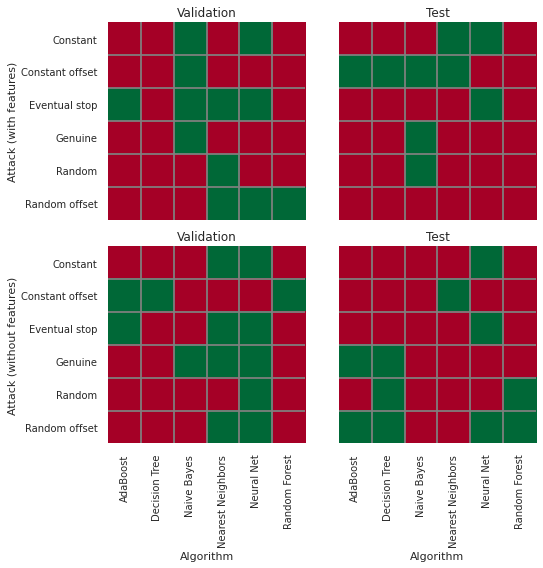

In [116]:
n_rows=2
n_cols=2
id_sub= iter(np.arange(1,20))
plt.subplots(n_rows,n_cols,figsize=(8,8))
names_y_label = iter(['with features','without features'])
for feature in ['True','False']:
    for multiclass in ['False']:
        for split  in ['train','test']:
            print(split,feature,multiclass)
            id_c=next(id_sub)
            plt.subplot(n_rows,n_cols,id_c)
            matrix=(all_results.loc[(slice(None),'our',split,feature,multiclass),(slice(None),'f1-score')].reset_index(['split',	'Set'	,'features',	'multiclass'],drop=True)
                   >all_results.loc[(slice(None),'random',split,feature,multiclass),(slice(None),'f1-score')].reset_index(['split',	'Set'	,'features',	'multiclass'],drop=True))
            plt.imshow(matrix,cmap=plt.cm.RdYlGn)
            for x in range(5):
                plt.axvline(x+0.5,c='grey')
                plt.axhline(x+0.5,c='grey')
                
            if id_c > n_cols*(n_rows-1):
                plt.xticks(ticks=range(6),labels=list(matrix.droplevel(1,axis=1).columns),rotation=90)
                plt.xlabel('Algorithm')
            else : plt.xticks([])
            if id_c%2 == 1 : 
                plt.yticks(ticks=range(6),labels=list(matrix.index),rotation=0)
                plt.title('Validation')
                plt.ylabel('Attack ('+next(names_y_label)+')' )
            else : 
                plt.yticks(ticks=[])
                plt.title('Test')
#                 plt.twinx()
#                 plt.yticks(ticks=[])

#                 plt.ylabel(next(names_y_label))
#             plt.colorbar()
plt.tight_layout()
plt.savefig("out/heatmap_results.png",dpi=600,bbox_inches='tight');

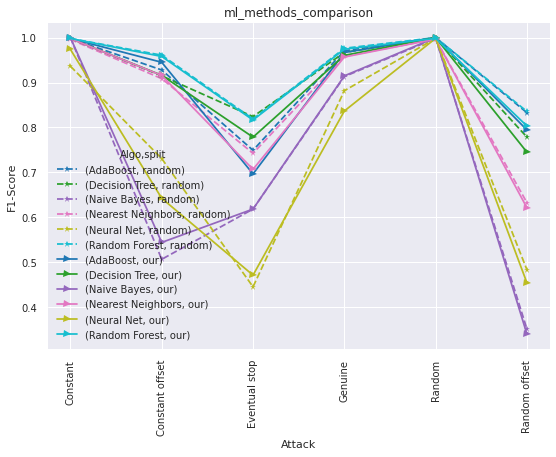

In [117]:
ax=all_results.loc[(slice(None),'random','test','True','False'),(slice(None),'f1-score')].droplevel(['multiclass','features','Set']).droplevel(1,axis=1).unstack('split').plot(rot=90,marker='*',style='--',cmap= plt.cm.tab10,figsize=(9,6))
all_results.loc[(slice(None),'our','test','True','False'),(slice(None),'f1-score')].droplevel(['multiclass','features','Set']).droplevel(1,axis=1).unstack('split').plot(rot=90,marker='>',ax=ax,cmap= plt.cm.tab10)
plt.grid()
plt.ylabel('F1-Score')
plt.title('ml_methods_comparison')

plt.savefig("out/ml_methods_comparison.png",dpi=600,bbox_inches='tight');


### results table

In [118]:
all_results.loc[(slice(None),'our','train',slice(None),'False'),(slice(None),'f1-score')].reset_index()

Algo,Attack,split,Set,features,multiclass,AdaBoost,Decision Tree,Naive Bayes,Nearest Neighbors,Neural Net,Random Forest
,,,,,,f1-score,f1-score,f1-score,f1-score,f1-score,f1-score
0,Constant,our,train,False,False,0.997519,0.997519,1.000000,0.987715,0.872017,0.997519
1,Constant,our,train,True,False,0.997519,0.997519,0.992481,0.987715,0.972152,0.997519
2,Constant offset,our,train,False,False,0.950920,0.975309,0.102857,0.910256,0.599222,0.984802
3,Constant offset,our,train,True,False,0.951515,0.963415,0.574850,0.911392,0.638596,0.959752
4,Eventual stop,our,train,False,False,0.676385,0.836565,0.261224,0.779221,0.657061,0.868633
5,Eventual stop,our,train,True,False,0.777143,0.857909,0.710059,0.780612,0.630332,0.867925
6,Genuine,our,train,False,False,0.953757,0.966378,0.903655,0.952233,0.876283,0.974244
7,Genuine,our,train,True,False,0.962792,0.971758,0.916662,0.951998,0.850917,0.973549
8,Random,our,train,False,False,0.995575,0.995575,0.986607,0.988864,1.000000,0.993348


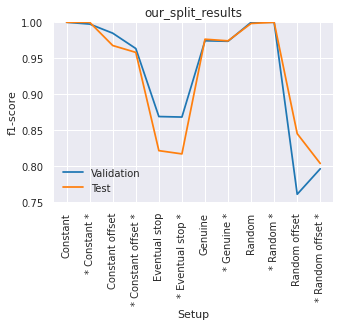

In [119]:
plt.figure(figsize=(5,3.3))
all_results.loc[(slice(None),'our','train',slice(None),'False'),(slice(None),'f1-score')].max(axis=1).plot(rot=90,use_index=False,label='Validation')
all_results.loc[(slice(None),'our','test',slice(None),'False'),(slice(None),'f1-score')].max(axis=1).plot(rot=90,use_index=False,label='Test')
plt.ylim(0.75,1)
plt.legend()
nms=['* ' if i%2==1 else '' for i in range(12) ]+all_results.loc[(slice(None),'our','train',slice(None),'False'),(slice(None),'f1-score')].reset_index()[['Attack']].Attack.values+[' *' if i%2==1 else '' for i in range(12) ]
plt.xticks(range(12),nms)
plt.xlabel('Setup')
plt.ylabel('f1-score')
plt.grid()
plt.title('our_split_results')

plt.savefig("out/our_split_results.png",dpi=600,bbox_inches='tight');

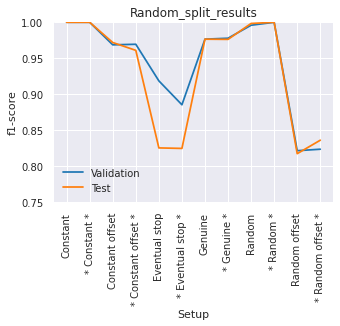

In [120]:
plt.figure(figsize=(5,3.3))
all_results.loc[(slice(None),'random','train',slice(None),'False'),(slice(None),'f1-score')].max(axis=1).plot(rot=90,use_index=False,label='Validation')
all_results.loc[(slice(None),'random','test',slice(None),'False'),(slice(None),'f1-score')].max(axis=1).plot(rot=90,use_index=False,label='Test')
plt.ylim(0.75,1)
plt.legend()
nms=['* ' if i%2==1 else '' for i in range(12) ]+all_results.loc[(slice(None),'random','train',slice(None),'False'),(slice(None),'f1-score')].reset_index()[['Attack']].Attack.values+[' *' if i%2==1 else '' for i in range(12) ]
plt.xticks(range(12),nms)
plt.xlabel('Setup')
plt.grid()
plt.ylabel('f1-score')
plt.title('Random_split_results')

plt.savefig("out/Random_split_results.png",dpi=600,bbox_inches='tight');

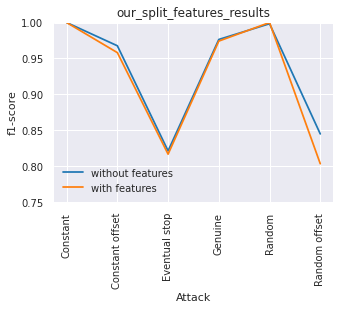

In [121]:
plt.figure(figsize=(5,3.3))
all_results.loc[(slice(None),'our','test','False','False'),(slice(None),'f1-score')].max(axis=1).plot(rot=90,use_index=False,label='without features')
all_results.loc[(slice(None),'our','test','True','False'),(slice(None),'f1-score')].max(axis=1).plot(rot=90,use_index=False,label='with features')
plt.ylim(0.75,1)
plt.legend()
nms=all_results.loc[(slice(None),'our','test','True','False'),(slice(None),'f1-score')].reset_index()[['Attack']].Attack.values
plt.xticks(range(6),nms)
plt.xlabel('Attack')
plt.ylabel('f1-score')
plt.grid()
plt.title('our_split_features_results')

plt.savefig("out/our_split_features_results.png",dpi=600,bbox_inches='tight');

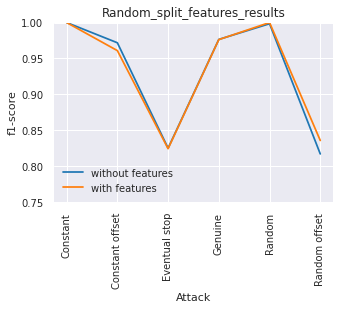

In [122]:
plt.figure(figsize=(5,3.3))
all_results.loc[(slice(None),'random','test','False','False'),(slice(None),'f1-score')].max(axis=1).plot(rot=90,use_index=False,label='without features')
all_results.loc[(slice(None),'random','test','True','False'),(slice(None),'f1-score')].max(axis=1).plot(rot=90,use_index=False,label='with features')
plt.ylim(0.75,1)
nms=all_results.loc[(slice(None),'random','test','True','False'),(slice(None),'f1-score')].reset_index()[['Attack']].Attack.values
plt.xticks(range(6),nms)
plt.legend()
plt.xlabel('Attack')
plt.ylabel('f1-score')
plt.grid()
plt.title('Random_split_features_results')
plt.savefig("out/Random_split_features_results.png",dpi=600,bbox_inches='tight');